In [ ]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# read the raw CSV files (BTC dominance + political events)
btc = pd.read_csv("BTC_D_dataset.csv")


events = pd.read_csv("political_events_2020_2025.csv")

# clean BTC dominance data
# convert time column to real dates and keep only date + close value
btc["date"] = pd.to_datetime(btc["time"], dayfirst=True)


btc["btc_dominance"] = btc["close"]


btc = btc[["date", "btc_dominance"]]


btc = btc.sort_values("date")

btc.head()


/tmp/ipython-input-1409034264.py:12: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  btc["date"] = pd.to_datetime(btc["time"], dayfirst=True)


,date,btc_dominance
0,2023-05-26,47.809404
1,2023-05-27,47.888934
2,2023-05-28,48.327372
3,2023-05-29,48.175823
4,2023-05-30,47.992350


In [ ]:
# clean political events data (make date column datetime)
events["date"] = pd.to_datetime(events["date"], dayfirst=True, errors="raise")
events.head()


,date,event_name,category,severity,region
0,2020-01-03,USA-Iran conflict escalation after Soleimani s...,war,high,Middle East
1,2020-03-11,WHO declares COVID-19 global pandemic,crisis,high,Global
2,2020-11-03,US Presidential Election,election,high,USA
3,2021-01-06,US Capitol Riot political crisis,crisis,medium,USA
4,2021-05-19,China intensifies national crypto crackdown,regulation,high,China


In [ ]:

#merge BTC dominance with political events on the date
merged = pd.merge(
    btc,
    events,
    on="date",
    how="left"
)

merged["event_flag"] = merged["event_name"].notna().astype(int)
merged.head()


,date,btc_dominance,event_name,category,severity,region,event_flag
0,2023-05-26,47.809404,NaN,NaN,NaN,NaN,0
1,2023-05-27,47.888934,NaN,NaN,NaN,NaN,0
2,2023-05-28,48.327372,NaN,NaN,NaN,NaN,0
3,2023-05-29,48.175823,NaN,NaN,NaN,NaN,0
4,2023-05-30,47.992350,NaN,NaN,NaN,NaN,0


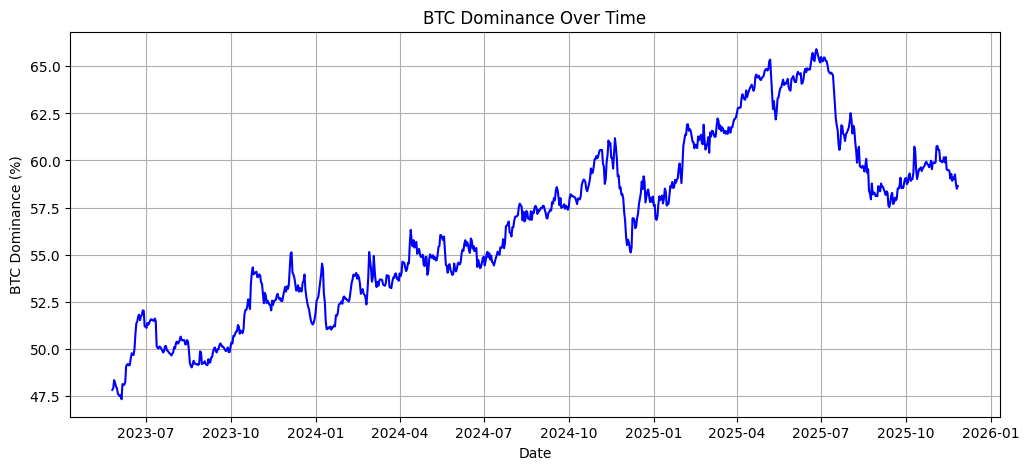

In [ ]:

#plot BTC dominance over time
plt.figure(figsize=(12,5))
plt.plot(merged["date"], merged["btc_dominance"], color="blue")
plt.title("BTC Dominance Over Time")
plt.xlabel("Date")
plt.ylabel("BTC Dominance (%)")
plt.grid(True)
plt.show()


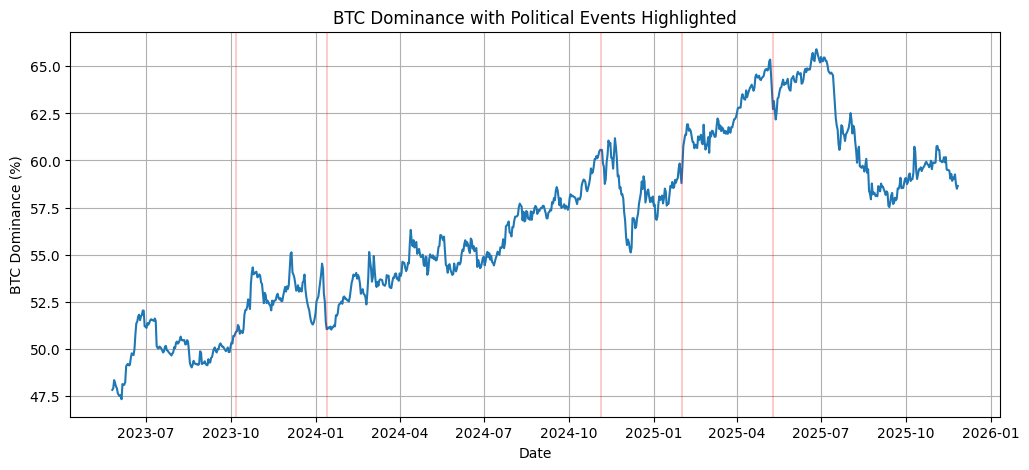

In [ ]:

#plot BTC dominance and mark political event days with vertical lines
plt.figure(figsize=(12,5))
plt.plot(merged["date"], merged["btc_dominance"], label="BTC Dominance")


for d in merged.loc[merged["event_flag"]==1, "date"]:
    plt.axvline(d, color="red", alpha=0.2)

plt.title("BTC Dominance with Political Events Highlighted")
plt.xlabel("Date")
plt.ylabel("BTC Dominance (%)")
plt.grid(True)
plt.show()


In [ ]:

# compare BTC dominance on event days vs normal days

event_days = merged[merged["event_flag"]==1]["btc_dominance"]
normal_days = merged[merged["event_flag"]==0]["btc_dominance"]

print("Average BTC dominance on event days:", event_days.mean())
print("Average BTC dominance on normal days:", normal_days.mean())

# simple t-test between event and non-event days
t_stat, p_val = ttest_ind(event_days, normal_days, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_val)


Average BTC dominance on event days: 56.98212081467344
Average BTC dominance on normal days: 56.62774437230378
t-statistic: 0.14123184080081558
p-value: 0.8944672821859021


In [ ]:
merged.to_csv("btc_dominance_with_events.csv", index=False)
